## Analysis of 311 Call data for the cities of Washington, Boston, Chicago and Buffalo with prediction of the estimated resolution time.

#### The 311 hotline is a special phone number for reporting non-emergencies and getting information about local services
#### With the data of the 311 hotline, we have decided to analyze the requests coming in for Boston, Buffalo, Chicago, Washington. 
#### Our analysis helps in checking the average resolution time, number of cases each department receives in each city and many more. 

In [16]:
import pandas as pd
from tabulate import tabulate
import sqlite3
from sqlite3 import Error
import os
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

#### Because yearly data is available separately, we had data split into several CSV files for some cities. To fix this, we created a function that will join all related CSV files into one file using the following code.

In [2]:
def combine_files(files_list,name):
    first_file=files_list[0]
    with open(first_file,"r") as temp:
        head=temp.readline()
    with open(name,"w") as fi2:
            fi2.write(head)
    for x in files_list:
        with open(x,"r") as fi:
            k=fi.read()
        k=k.split("\n")
        for y in range(1,len(k)):
             with open(name,"a") as fi2:
                  fi2.write(k[y])
                  fi2.write("\n")

In [4]:
#combine_files(['DC2021.csv','dc2022.csv','dc2023.csv'],'dc.csv')

The Import.db database file was created for this project. It was utilized to import the raw CSV files, aggregate the raw tables into a single non-normalized table, and subsequently partition the non-normalized data into normalized tables.  

#### Functions used for effective importing of raw data

create_connection : which will create a database connection and return the conn as the output  

 Create_table : which takes a create table sql statement and executes using the connection provided  
 

In [36]:
def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

create_table_statement :  This function is used to create the "Create table" sql statement for a given table

create_insert_statement :  This function is used to create the "Insert into table " sql statement for a given table

In [37]:
def create_table_statement(header,table):
    create_stat=f"CREATE TABLE {table}( \n"
    for x,y in enumerate(header.split(",")):
        if x==len(header.split(","))-1:
            create_stat+=f'"{y}" TEXT );'
        else:
            create_stat+=f'"{y}" TEXT,\n'
    return create_stat


def create_insert_statement(row_string,table):
    s=f"INSERT INTO {table} VALUES("
    for x,y in enumerate(row_string.split(",")):
        if x==len(row_string.split(","))-1:
            s+=f"'{y}')"
        else:
            s+=f"'{y}',"
    return(s)



load_csv function to ingest raw csv files into tables in database.

In [6]:
def load_csv(filename,db_name,re_create_db=False):
    db=db_name
    conn = create_connection(db)
    file=filename
    table=file[:-4]
    line_num=0
    c=0
    with open(file,'r') as f:
        for line in f:
            if line_num==0:
                header=line.replace(" ","_").replace("'","_")
                cre=create_table_statement(header,table)
                with conn:
                    create_table(conn, cre)
                line_num+=1
            else:
                k=line.replace("'","_")
                p=create_insert_statement(k,table)
                with conn:
                    cur = conn.cursor()
                    try:
                        cur.execute(p)
                        conn.commit()
                        #print(f"Inserted:{p}")  
                    except Exception as e:
                        ignored=p
                        ignored_line=line
                        print(ignored)
                        print(ignored_line)
                        c+=1
                        #conn.close()
    print(f"skipped rows {c}")


In [7]:
load_csv('Boston.csv','import.db')
load_csv('new_buffalo.csv','import.db')
load_csv('new_chicago.csv','import.db')
load_csv('new_dc.csv','import.db')

INSERT INTO Boston VALUES('
')


skipped rows 1
skipped rows 0
skipped rows 0
INSERT INTO new_dc VALUES('
')


skipped rows 1


Create a non normalised table from all the tables, this will also make sure all the columns are same name

In [8]:
db='import.db'
conn = create_connection(db)
cur = conn.cursor()
cur.execute('''create table 'non_normalised' as
SELECT
    case_enquiry_id,
    replace(open_dt, "_", " ") as open_dt,
    replace(closed_dt, "_", " ") as closed_dt,
    case_status,
    type,
    department,
    "Boston" city,
    "massachusetts" state,
    location_zipcode
FROM
    Boston
union
ALL
select
    Case_Reference,
    SUBSTR(Open_Date, 7, 4) || '-' || -- Year
    SUBSTR(Open_Date, 1, 2) || '-' || -- Month
    SUBSTR(Open_Date, 4, 2) || ' ' || -- Day
    SUBSTR(Open_Date, 12, 8) -- Time
    AS Open_Date,
    SUBSTR(Closed_Date, 7, 4) || '-' || -- Year
    SUBSTR(Closed_Date, 1, 2) || '-' || -- Month
    SUBSTR(Closed_Date, 4, 2) || ' ' || -- Day
    SUBSTR(Closed_Date, 12, 8) -- Time
    AS Closed_Date,
    Status,
    Type,
    department,
    City,
    State,
    Zipcode
from
    (
        select
            Case_Reference,
            case
                when substr(Open_Date, 21, 2) == 'AM'
                and CAST(substr(Open_Date, 12, 2) AS INTEGER) != 12 then substr(Open_Date, 1, 19)
                when substr(Open_Date, 21, 2) == 'PM'
                and CAST(substr(Open_Date, 12, 2) AS INTEGER) == 12 then substr(Open_Date, 1, 19)
                when substr(Open_Date, 21, 2) == 'AM'
                and CAST(substr(Open_Date, 12, 2) AS INTEGER) == 12 then substr(Open_Date, 1, 11) || '00' || substr(Open_Date, 14, 6)
                when substr(Open_Date, 21, 2) == 'PM'
                and CAST(substr(Open_Date, 12, 2) AS INTEGER) != 12 then substr(Open_Date, 1, 11) || CAST(
                    CAST(substr(Open_Date, 12, 2) AS INTEGER) + 12 AS TEXT
                ) || substr(Open_Date, 14, 6)
            end as Open_Date,
            case
                when substr(Closed_Date, 21, 2) == 'AM'
                and CAST(substr(Closed_Date, 12, 2) AS INTEGER) != 12 then substr(Closed_Date, 1, 19)
                when substr(Closed_Date, 21, 2) == 'PM'
                and CAST(substr(Closed_Date, 12, 2) AS INTEGER) == 12 then substr(Closed_Date, 1, 19)
                when substr(Closed_Date, 21, 2) == 'AM'
                and CAST(substr(Closed_Date, 12, 2) AS INTEGER) == 12 then substr(Closed_Date, 1, 11) || '00' || substr(Closed_Date, 14, 6)
                when substr(Closed_Date, 21, 2) == 'PM'
                and CAST(substr(Closed_Date, 12, 2) AS INTEGER) != 12 then substr(Closed_Date, 1, 11) || CAST(
                    CAST(substr(Closed_Date, 12, 2) AS INTEGER) + 12 AS TEXT
                ) || substr(Closed_Date, 14, 6)
            end as Closed_Date,
            Status,
            Type,
            department,
            City,
            State,
            Zipcode
        from
            (
                SELECT
                    Case_Reference,
                    replace(Open_Date, "_", " ") as Open_Date,
                    replace(Closed_Date, "_", " ") as Closed_Date,
                    Status,
                    Type,
                    Subject as department,
                    City,
                    State,
                    Zipcode
                FROM
                    new_buffalo
            )
    )
union
ALL
select
    SR_NUMBER,
    SUBSTR(CREATED_DATE, 7, 4) || '-' || -- Year
    SUBSTR(CREATED_DATE, 1, 2) || '-' || -- Month
    SUBSTR(CREATED_DATE, 4, 2) || ' ' || -- Day
    SUBSTR(CREATED_DATE, 12, 8) -- Time
    AS CREATED_DATE,
    SUBSTR(CLOSED_DATE, 7, 4) || '-' || -- Year
    SUBSTR(CLOSED_DATE, 1, 2) || '-' || -- Month
    SUBSTR(CLOSED_DATE, 4, 2) || ' ' || -- Day
    SUBSTR(CLOSED_DATE, 12, 8) -- Time
    AS CLOSED_DATE,
    STATUS,
    SR_TYPE,
    OWNER_DEPARTMENT,
    CITY,
    STATE,
    ZIP_CODE
from
    (
        select
            SR_NUMBER,
            case
                when substr(CREATED_DATE, 21, 2) == 'AM'
                and CAST(substr(CREATED_DATE, 12, 2) AS INTEGER) != 12 then substr(CREATED_DATE, 1, 19)
                when substr(CREATED_DATE, 21, 2) == 'PM'
                and CAST(substr(CREATED_DATE, 12, 2) AS INTEGER) == 12 then substr(CREATED_DATE, 1, 19)
                when substr(CREATED_DATE, 21, 2) == 'AM'
                and CAST(substr(CREATED_DATE, 12, 2) AS INTEGER) == 12 then substr(CREATED_DATE, 1, 11) || '00' || substr(CREATED_DATE, 14, 6)
                when substr(CREATED_DATE, 21, 2) == 'PM'
                and CAST(substr(CREATED_DATE, 12, 2) AS INTEGER) != 12 then substr(CREATED_DATE, 1, 11) || CAST(
                    CAST(substr(CREATED_DATE, 12, 2) AS INTEGER) + 12 AS TEXT
                ) || substr(CREATED_DATE, 14, 6)
            end as CREATED_DATE,
            case
                when substr(CLOSED_DATE, 21, 2) == 'AM'
                and CAST(substr(CLOSED_DATE, 12, 2) AS INTEGER) != 12 then substr(CLOSED_DATE, 1, 19)
                when substr(CLOSED_DATE, 21, 2) == 'PM'
                and CAST(substr(CLOSED_DATE, 12, 2) AS INTEGER) == 12 then substr(CLOSED_DATE, 1, 19)
                when substr(CLOSED_DATE, 21, 2) == 'AM'
                and CAST(substr(CLOSED_DATE, 12, 2) AS INTEGER) == 12 then substr(CLOSED_DATE, 1, 11) || '00' || substr(CLOSED_DATE, 14, 6)
                when substr(CLOSED_DATE, 21, 2) == 'PM'
                and CAST(substr(CLOSED_DATE, 12, 2) AS INTEGER) != 12 then substr(CLOSED_DATE, 1, 11) || CAST(
                    CAST(substr(CLOSED_DATE, 12, 2) AS INTEGER) + 12 AS TEXT
                ) || substr(CLOSED_DATE, 14, 6)
            end as CLOSED_DATE,
            STATUS,
            SR_TYPE,
            OWNER_DEPARTMENT,
            CITY,
            STATE,
            ZIP_CODE
        from
            (
                SELECT
                    SR_NUMBER,
                    --
                    replace(CREATED_DATE, "_", " ") as CREATED_DATE,
                    --
                    replace(CLOSED_DATE, "_", " ") as CLOSED_DATE,
                    --
                    STATUS,
                    --
                    SR_TYPE,
                    --
                    OWNER_DEPARTMENT,
                    --
                    case
                        CITY
                        when '' then 'chicago'
                        else CITY
                    end as CITY,
                    case
                        STATE
                        when '' then 'IL'
                        else STATE
                    end as STATE,
                    ZIP_CODE --
                FROM
                    new_chicago
            )
    )
union
ALL
select
    OBJECTID,
    SUBSTR(substr(ADDDATE, 1, 19), 1, 4) || '-' || -- Year
    SUBSTR(substr(ADDDATE, 1, 19), 6, 2) || '-' || -- Month
    SUBSTR(substr(ADDDATE, 1, 19), 9, 2) || ' ' || -- Day
    SUBSTR(substr(ADDDATE, 1, 19), 12, 8) -- Time
    AS ADDDATE,
    SUBSTR(substr(RESOLUTIONDATE, 1, 19), 1, 4) || '-' || -- Year
    SUBSTR(substr(RESOLUTIONDATE, 1, 19), 6, 2) || '-' || -- Month
    SUBSTR(substr(RESOLUTIONDATE, 1, 19), 9, 2) || ' ' || -- Day
    SUBSTR(substr(RESOLUTIONDATE, 1, 19), 12, 8) -- Time
    AS RESOLUTIONDATE,
    STATUS_CODE,
    SERVICETYPECODEDESCRIPTION,
    department_name,
    CITY,
    --
    STATE,
    --
    ZIPCODE -- 
from
    (
        SELECT
            OBJECTID,
            --
            replace(ADDDATE, "_", " ") as ADDDATE,
            --
            replace(RESOLUTIONDATE, "_", " ") as RESOLUTIONDATE,
            --
            "closed" as STATUS_CODE,
            --
            SERVICETYPECODEDESCRIPTION,
            --
            CASE
                ORGANIZATIONACRONYM
                WHEN 'DPW' THEN 'Department of Public Works'
                WHEN 'DOH' THEN 'Department of Health'
                WHEN 'DDOT' THEN 'District Department of Transportation'
                WHEN 'DMV' THEN 'Department of Motor Vehicles'
                WHEN 'DOB' THEN 'Department of Buildings'
                WHEN 'DGS' THEN 'Department of General Services'
                WHEN 'OUC' THEN 'Office of Unified Communications'
                WHEN 'DOEE' THEN 'Department of Energy and Environment'
                WHEN 'ORM' THEN 'Office of Risk Management'
                WHEN 'FEMS' THEN 'Fire and Emergency Medical Services Department'
                WHEN 'DC Water' THEN 'District of Columbia Water and Sewer Authority'
                WHEN 'DFHV' THEN 'Department of For-Hire Vehicles'
                WHEN 'CFSA' THEN 'Child and Family Services Agency'
                ELSE 'Unknown'
            END as department_name,
            CITY,
            --
            STATE,
            --
            ZIPCODE --
        FROM
            new_dc
    )
''')

In [9]:
conn.close()

We created 2 more functions to help in created the normalised tables

In [10]:
def insert_into_table(statement, values,conn):
    sql =statement 
    cur = conn.cursor()
    for value in values:
        cur.execute(sql, value)
    conn.commit()
    return cur.lastrowid

def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)
    rows = cur.fetchall()
    return rows

we created 3 normalised tables

Location table 

departments table  

reported_311_cases table

Location table : 

In [11]:
db='import.db'
conn = create_connection(db)
create_location_statement='''
CREATE TABLE location (
    location_key INTEGER PRIMARY KEY AUTOINCREMENT,
    city TEXT,
    state TEXT,
    zipcode INTEGER
);
'''
sql_statement_insert_location='''
select distinct lower(city) as city,
case lower(state)
    when 'ny' then 'new_york'
    when 'il' then 'illinois'
    else lower(state)
    end as state,
case location_zipcode 
    when '' then 0
    else CAST(location_zipcode AS INTEGER)
    end as zipcode
from non_normalised;
'''
sql_insert_location=''' INSERT INTO location(city,state,zipcode)
VALUES(?,?,?) '''


rows=execute_sql_statement(sql_statement_insert_location,conn)
create_table(conn,create_location_statement)
insert_into_table(sql_insert_location,rows,conn)

342

departments table 

In [12]:
create_department_statement='''
CREATE TABLE departments(
   department_key INTEGER PRIMARY KEY AUTOINCREMENT,
   department TEXT
);
'''
sql_statement_insert_department='''
select distinct department
from non_normalised
'''
sql_insert_department=''' INSERT INTO departments(department)
VALUES(?) '''
rows=execute_sql_statement(sql_statement_insert_department,conn)
create_table(conn,create_department_statement)
insert_into_table(sql_insert_department,rows,conn)

64

reported_311_cases table

In [13]:
create_cases_statement='''
CREATE TABLE reported_311_cases (
    case_reference_key INTEGER PRIMARY KEY AUTOINCREMENT,
    case_number TEXT,
    open_date TEXT,
    close_date TEXT,
    case_status TEXT,
    type TEXT,
    department_key INTEGER,
    location_key INTEGER,
    FOREIGN KEY (department_key) REFERENCES departments(department_key),
    FOREIGN KEY (location_key) REFERENCES location(location_key)
);
'''
sql_statement_insert_cases='''
select case_enquiry_id case_number,
open_dt,
closed_dt,
case_status,
type,
d.department_key,
l.location_key 
from(
SELECT case_enquiry_id,
open_dt,
closed_dt,
case_status,
type,
department,lower(city) as city,
case lower(state)
    when 'ny' then 'new_york'
    when 'il' then 'illinois'
    else lower(state)
    end as state,
case location_zipcode 
    when '' then 0
    else CAST(location_zipcode AS INTEGER)
    end as zipcode
FROM non_normalised) as nn
join departments d on nn.department = d.department
join location l on nn.city=l.city and nn.state=l.state and nn.zipcode=l.zipcode
'''
sql_insert_cases=''' INSERT INTO reported_311_cases(case_number,open_date,close_date,case_status,type,department_key,location_key)
VALUES(?,?,?,?,?,?,?) '''
rows=execute_sql_statement(sql_statement_insert_cases,conn)
create_table(conn,create_cases_statement)
insert_into_table(sql_insert_cases,rows,conn)

10872368

#### Flow Chart representing the flow of Data from Raw CSV files to Normalised tables which are ready for analysis  

![Flow Chart](diagram.jpg)

### Analysis From normalised data

#### Hour of the day vs No of tickets in 2022

In [14]:
db='import.db'
conn = create_connection(db)
query = ''' 
select  strftime('%H', open_date) as time_of_day,count( case_number) as case_count
from reported_311_cases rc
join departments as d on rc.department_key = d.department_key
join location as l on rc.location_key = l.location_key
where zipcode!=0 and department!='' and type !='' and strftime('%Y', open_date) = '2022'
group by strftime('%H', open_date)
order by 1     
'''
df_main = pd.read_sql_query(query, conn)
display(df_main)

,time_of_day,case_count
0,00,19784
1,01,15463
2,02,10226
3,03,8344
4,04,10159
5,05,16366
6,06,36380
7,07,86396
8,08,112223
9,09,133014


An hourly distribution of the number of tickets opened in 2022 represented by a bar graph.

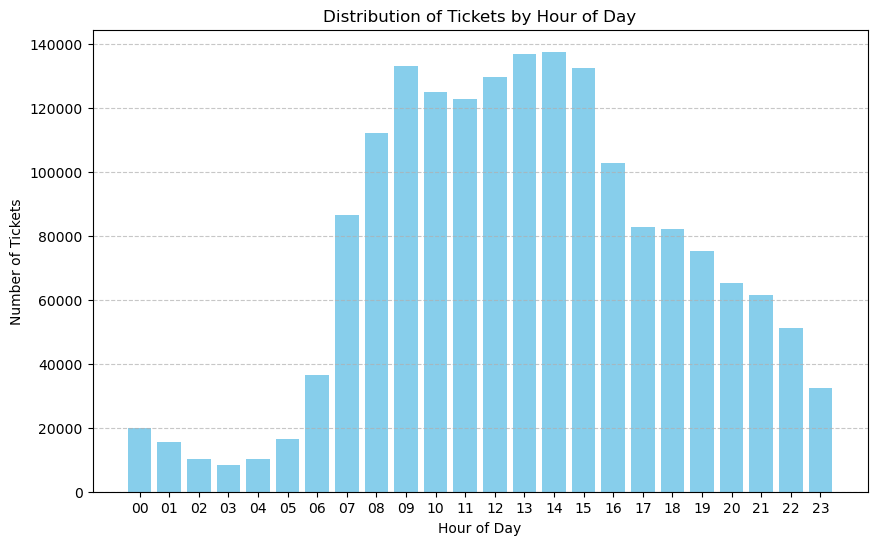

In [17]:
plt.figure(figsize=(10, 6))
plt.bar(df_main['time_of_day'], df_main['case_count'], color='skyblue')
plt.title('Distribution of Tickets by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Tickets')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

Top 5 requests in each season of 2022 in buffalo city

In [18]:
query = ''' 
select
    *
from
    (
        select
            season,
            type,
            department,
            number_of_requests,
            row_number() over (
                partition by season
                order by
                    number_of_requests desc
            ) as ranking
        from
            (
                select
                    distinct season,
                    type,
                    department,
                    count(case_number) over (partition by season, type) as number_of_requests
                from
(
                        select
                            case
                                when strftime('%m', open_date) in('12', '01', '02') then 'winter'
                                when strftime('%m', open_date) in('03', '04', '05') then 'spring'
                                when strftime('%m', open_date) in('06', '07', '08') then 'summer'
                                when strftime('%m', open_date) in('09', '10', '11') then 'fall'
                            end as season,
                            type,
                            department,
                            case_number
                        from
                            reported_311_cases rc
                            join departments as d on rc.department_key = d.department_key
                            join location as l on rc.location_key = l.location_key
                        where
                            lower(city) = 'buffalo'
                            and strftime('%Y', open_date) = '2022'
                    )
            )
    )
where
    ranking <= 5
order by
    1,
    5    
'''
df_main = pd.read_sql_query(query, conn)
display(df_main)

,season,type,department,number_of_requests,ranking
0,fall,Street Snow Plowing (Req_Serv),Dept of Public Works,2257,1
1,fall,Housing Violations (Req_Serv),DPIS,1977,2
2,fall,Garbage Missed Pick Up (Req_Serv),Dept of Public Works,1529,3
3,fall,Totes Replace (Req_Serv),Dept of Public Works,1518,4
4,fall,Parking Issues (Req_Serv),Dept of Parking,1195,5
5,spring,Housing Violations (Req_Serv),DPIS,3447,1
6,spring,Pot Hole (Req_Serv),Dept of Public Works,1910,2
7,spring,Totes Replace (Req_Serv),Dept of Public Works,1869,3
8,spring,Garbage Missed Pick Up (Req_Serv),Dept of Public Works,1503,4
9,spring,Parking Issues (Req_Serv),Dept of Parking,894,5


4 sub plots showing top 5 requests in each season  -  Fall , Winter , Spring, Summar

C:\Users\ysiva\AppData\Local\Temp\ipykernel_21316\2131273384.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(season_data['type'], rotation=90, ha='center')
C:\Users\ysiva\AppData\Local\Temp\ipykernel_21316\2131273384.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(season_data['type'], rotation=90, ha='center')
C:\Users\ysiva\AppData\Local\Temp\ipykernel_21316\2131273384.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(season_data['type'], rotation=90, ha='center')
C:\Users\ysiva\AppData\Local\Temp\ipykernel_21316\2131273384.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xti

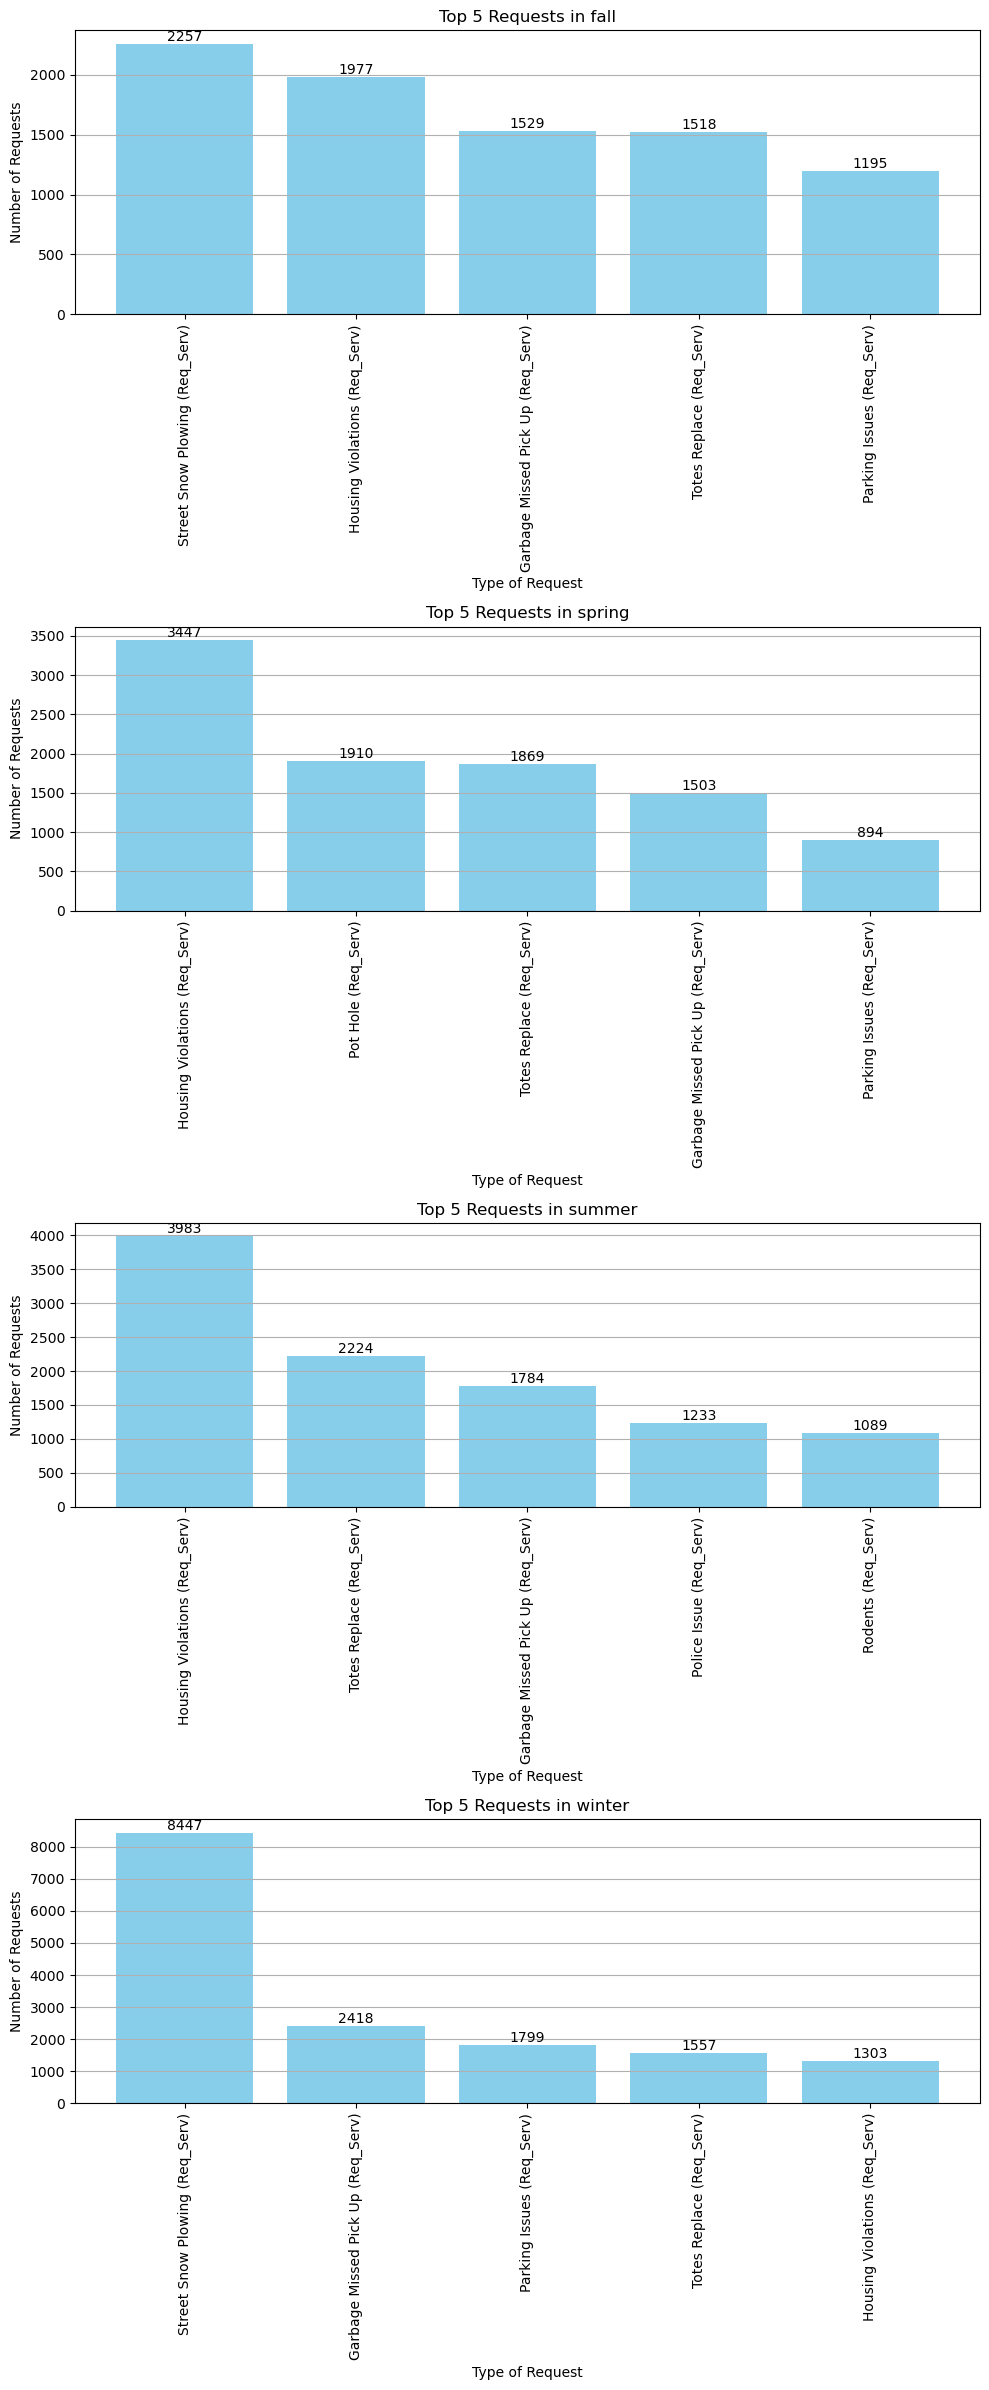

In [19]:
seasons = df_main['season'].unique()
fig, axes = plt.subplots(nrows=len(seasons), ncols=1, figsize=(10, 6 * len(seasons)))


for i, season in enumerate(seasons):
    ax = axes[i]
    season_data = df_main[df_main['season'] == season].sort_values(by='ranking')
    bars = ax.bar(season_data['type'], season_data['number_of_requests'], color='skyblue')
    ax.set_title(f'Top 5 Requests in {season}')
    ax.set_xlabel('Type of Request')
    ax.set_ylabel('Number of Requests')
    ax.grid(axis='y')

    # Rotate x-axis labels vertically
    ax.set_xticklabels(season_data['type'], rotation=90, ha='center')

    # Add data labels
    for bar, label in zip(bars, season_data['number_of_requests']):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), label,
                ha='center', va='bottom')


plt.tight_layout() # fixing overlap 


plt.show()

Average resolution time in minutes for each city in 2022

In [20]:
query = ''' 
select
    city,
    round(avg_case_resolution_time_min, 2) as avg_case_resolution_time_min
from
    (
        select
            DISTINCT l.city,
            AVG(
                round(
                    (julianday(close_date) - julianday(open_date)) *(24 * 60),
                    2
                )
            ) avg_case_resolution_time_min
        from
            reported_311_cases rp
            join location as l on rp.location_key = l.location_key
        where
            lower(case_status) != 'open'
            and strftime('%Y', open_date) = '2022'
        group BY
            l.city
    );    
'''
df_main = pd.read_sql_query(query, conn)
display(df_main)

,city,avg_case_resolution_time_min
0,buffalo,19485.28
1,chicago,23631.92
2,washington,59306.41


Same query in pandas

In [21]:
query_reported_311_cases = ''' select * from reported_311_cases'''
reported_311_cases = pd.read_sql_query(query_reported_311_cases, conn)

query_location = '''select * from location '''
location = pd.read_sql_query(query_location, conn)

query_departments = '''select * from departments '''
departments = pd.read_sql_query(query_departments, conn)

In [22]:
merged_data = pd.merge(reported_311_cases, location, on='location_key')

filtered_data = merged_data[(merged_data['case_status'].str.lower() != 'open') &
                            (pd.to_datetime(merged_data['open_date']).dt.year == 2022)]

filtered_data['resolution_time_min'] = ((pd.to_datetime(filtered_data['close_date']) -
                                          pd.to_datetime(filtered_data['open_date'])).dt.total_seconds() / 60).round(2)

result_df = filtered_data.groupby('city')['resolution_time_min'].mean().reset_index()
result_df.columns = ['city', 'avg_case_resolution_time_min']

print(result_df)

         city  avg_case_resolution_time_min
0     buffalo                  19485.275549
1     chicago                  23631.915223
2  washington                  59306.411765


C:\Users\ysiva\AppData\Local\Temp\ipykernel_21316\3164450184.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['resolution_time_min'] = ((pd.to_datetime(filtered_data['close_date']) -


Department which handled highest number of cases in each city

In [23]:
query = ''' 
select
    city,
    department,
    case_count
from
    (
        select
            city,
            department,
            case_count,
            row_number() over (
                PARTITION by city
                order by
                    case_count desc
            ) as ran
        from
            (
                select
                    distinct l.city,
                    d.department,
                    count(case_number) over (partition by l.city, d.department) case_count
                from
                    reported_311_cases as rc
                    join departments as d on rc.department_key = d.department_key
                    join location as l on l.location_key = rc.location_key
                where
                    d.department != '' and strftime('%Y', open_date) = '2021'
            )
    )
where
    ran = 1   
'''
df_main = pd.read_sql_query(query, conn)
display(df_main)

,city,department,case_count
0,boston,PWDx,127447
1,buffalo,Dept of Public Works,50312
2,chicago,311 City Services,656348
3,washington,Department of Public Works,249279


same query using pandas

In [24]:
merged_data = pd.merge(reported_311_cases, departments, on='department_key')
merged_data = pd.merge(merged_data, location, on='location_key')

filtered_data = merged_data[(merged_data['department'] != '') & (pd.to_datetime(merged_data['open_date']).dt.year == 2021)]

filtered_data['case_count'] = filtered_data.groupby(['city', 'department'])['case_number'].transform('count')

filtered_data['ran'] = filtered_data.groupby('city')['case_count'].rank(ascending=False, method='first')

result_df = filtered_data[filtered_data['ran'] == 1][['city', 'department', 'case_count']].drop_duplicates()

print(result_df)

C:\Users\ysiva\AppData\Local\Temp\ipykernel_21316\2728025153.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['case_count'] = filtered_data.groupby(['city', 'department'])['case_number'].transform('count')
C:\Users\ysiva\AppData\Local\Temp\ipykernel_21316\2728025153.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['ran'] = filtered_data.groupby('city')['case_count'].rank(ascending=False, method='first')


                city                  department  case_count
0             boston                        PWDx      127447
273853       buffalo        Dept of Public Works       50312
2625132      chicago           311 City Services      656348
10511552  washington  Department of Public Works      249279


### Machine Learning Classification and Prediction

Our main aim was to make a predition on how long does requests take to be resolved based on factors like   
type of request  
department  
zipcode

Our initial intention was to utilize all the available data and incorporate city and state as predictive factors as well. However, we were unable to proceed with that plan due to limitations in system resources. Therefore, only Chicago data was utilized for the following prediction:

In [25]:
connection = sqlite3.connect('import.db')

For Prediction we have created 5 buckets   
1) Less than 1 day  
2) less than 3 days  
3) less than 6 days  
4) less than 9 days  
5) More than 9 days

In [26]:
query = ''' 
select 
            case
                when resolution_time < 1 then '1'
                when resolution_time < 3 then '3'
                when resolution_time < 6 then '6'
                when resolution_time < 9 then '9'
                else 'more than 9'
            end as resolution_days,
                    type,
                    department,
                    zipcode
        from
            (
                select
                    ABS(
                        round(
                            (julianday(close_date) - julianday(open_date)),
                            2
                        )
                    ) resolution_time,
                    type,
                    department,
                    city,
                    state,
                    zipcode
                from
                    reported_311_cases rc
                    join departments as d on rc.department_key = d.department_key
                    join location as l on rc.location_key = l.location_key
                    where lower(city) in ('chicago') and zipcode!=0 and department!='' and type !=''and strftime('%Y', open_date) = '2021'
            )
    
'''
df_main = pd.read_sql_query(query, connection)
connection.close()
display(df_main.head(2))

,resolution_days,type,department,zipcode
0,1,311 INFORMATION ONLY CALL,311 City Services,60612
1,1,311 INFORMATION ONLY CALL,311 City Services,60612


A simple bar graph to show the distribution of data accross each resolution bucket 

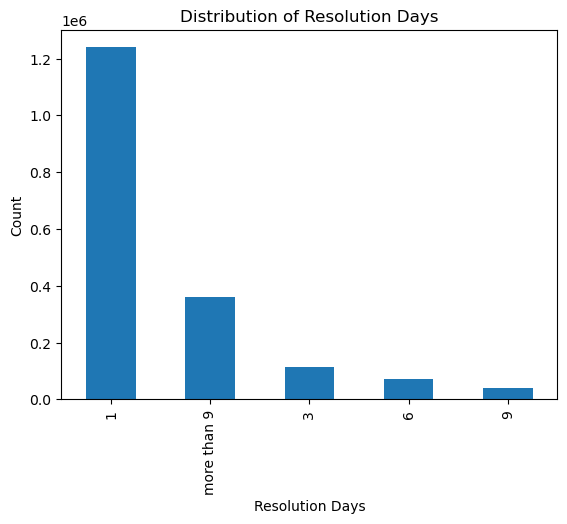

In [27]:
df_main['resolution_days'].value_counts().plot(kind='bar')
plt.title('Distribution of Resolution Days')
plt.xlabel('Resolution Days')
plt.ylabel('Count')
plt.show()

As all of our data is catagorical variables we have to encode them to convert into a binary 1,0 for classification

In [28]:
df_encoded = pd.get_dummies(df_main, columns=['type' ,'department','zipcode'])

Seperating into features and target variables

In [29]:
X = df_encoded.drop('resolution_days', axis=1)  # Features
y = df_encoded['resolution_days']  # Target variabl

Making a 80-20 split for training and testing data and seting seed to 42

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

using Naive bayes classifier and training the model

In [31]:
naive_bayes_classifier = GaussianNB()
naive_bayes_classifier.fit(X_train, y_train)

GaussianNB()

Making prediction on X_test

In [32]:
y_pred = naive_bayes_classifier.predict(X_test)

Calculating accuracy and classification report

In [33]:
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

Presenting the findings through accuracy ,classification report and confusion matrix

In [34]:
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:\n', classification_rep)
print('Confusion Matrix:\n', conf_matrix)

Accuracy: 0.6613338008722522
Classification Report:
               precision    recall  f1-score   support

           1       0.98      0.84      0.91    247834
           3       0.24      0.26      0.25     22872
           6       0.10      0.00      0.01     14138
           9       0.07      0.95      0.14      8083
 more than 9       0.87      0.27      0.41     72105

    accuracy                           0.66    365032
   macro avg       0.45      0.46      0.34    365032
weighted avg       0.86      0.66      0.72    365032

Confusion Matrix:
 [[208335  16960    220  20042   2277]
 [  2086   5990     81  14529    186]
 [   545   1555     52  11790    196]
 [    44    216     18   7658    147]
 [   999    735    133  50865  19373]]


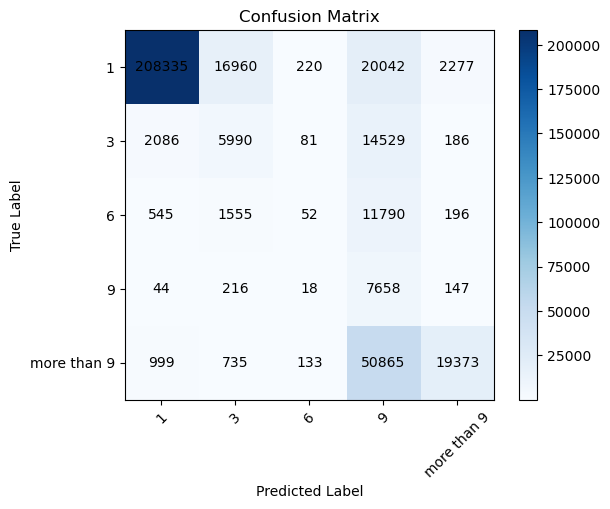

In [35]:
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = naive_bayes_classifier.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black')

plt.show()